# Introduction: 
This assignment is about building a multimodal deep learning model that generates natural language descriptions for images using a Sequence-to-Sequence (Seq2Seq) architecture.

# Environment Setup
We've created a notebook on **Kaggle**, and using the **Accelerator**: `GPU T4 x2 (Dual GPU)`

For the dataset, we're using the **Flickr30k** by *adityajn105*.

Link: https://www.kaggle.com/datasets/adityajn105/flickr30k


# Part 1: Feature Extraction Pipeline

In [4]:
import os, pickle, torch, torch.nn as nn, torch.optim as optim
import re, pandas as pd, nltk, numpy as np, random, matplotlib.pyplot as plt, gradio as gr
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [5]:
def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
    # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")


# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
features_dict = {}


with torch.no_grad():
 for imgs, names in tqdm(loader, desc="Extracting Features"):
     feats = model(imgs.to(device)).view(imgs.size(0), -1)
     for i, name in enumerate(names):
         features_dict[name] = feats[i].cpu().numpy()


with open(OUTPUT_FILE, 'wb') as f:
     pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:44<00:00,  2.39it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


# Part 2: Vocabulary & Text Pre-Processing

In [6]:
nltk.download('punkt')

# --- LOAD DATA ---
captions_file = '/kaggle/input/flickr30k/captions.txt'
dataframe = pd.read_csv(captions_file, sep=',')

print(f"Loaded {len(dataframe)} captions")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loaded 158915 captions


In [7]:
# --- CLEAN CAPTIONS ---
def clean_caption(caption):
    caption = str(caption).lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    caption = ' '.join(caption.split())
    return caption

dataframe['caption'] = dataframe['caption'].apply(clean_caption)
dataframe['tokens'] = dataframe['caption'].apply(lambda x: x.split())
dataframe['tokens'] = dataframe['tokens'].apply(lambda x: ['<start>'] + x + ['<end>'])
print("Example tokenized caption:")
print(dataframe['tokens'].iloc[0])

Example tokenized caption:
['<start>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<end>']


In [8]:
# --- BUILD VOCAB ---
# Collect all tokens from all captions
all_tokens = []
for token_list in dataframe['tokens']:
    all_tokens.extend(token_list)

token_counts = Counter(all_tokens)

# Filter by minimum frequency
MIN_FREQ = 5
vocab = [token for token, count in token_counts.items() if count >= MIN_FREQ]
special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
vocab = special_tokens + [v for v in vocab if v not in special_tokens]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

print(f"\nVocabulary size: {len(vocab)}")
print(f"Most common tokens: {token_counts.most_common(20)}")


Vocabulary size: 7689
Most common tokens: [('a', 271705), ('<start>', 158915), ('<end>', 158915), ('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41117), ('of', 38776), ('with', 36207), ('woman', 22211), ('two', 21642), ('are', 20196), ('to', 17607), ('people', 17337), ('at', 16259), ('an', 15883), ('wearing', 15709), ('young', 13218)]


In [9]:
# --- CONVERT TOKENS TO INDICES ---
def tokens_to_indices(tokens, word2idx):
    indices = []
    for token in tokens:
        if token in word2idx:
            indices.append(word2idx[token])
        else:
            indices.append(word2idx['<unk>'])
    return indices

dataframe['indices'] = dataframe['tokens'].apply(lambda x: tokens_to_indices(x, word2idx))

In [10]:
# --- CHOOSE MAX LENGTH ---
# Get length of each caption (in tokens)
caption_lengths = dataframe['tokens'].apply(len)

MAX_LENGTH = int(np.percentile(caption_lengths, 95))
print(f"\nUsing MAX_LENGTH: {MAX_LENGTH}")

# Check how many captions will be truncated
num_truncated = (caption_lengths > MAX_LENGTH).sum()
print(f"Captions to be truncated: {num_truncated} ({num_truncated/len(dataframe)*100:.2f}%)")


Using MAX_LENGTH: 24
Captions to be truncated: 6779 (4.27%)


In [11]:
# --- PADDING AND TRUNCATION FUNCTION ---
def pad_or_truncate(indices, max_length, pad_idx):
    if len(indices) > max_length:
        # Truncate (but keep <end> token)
        return indices[:max_length-1] + [indices[-1]]  # Keep <end>
    else:
        # Pad with <pad> tokens
        return indices + [pad_idx] * (max_length - len(indices))

# Apply padding/truncation
PAD_IDX = word2idx['<pad>']
dataframe['padded_indices'] = dataframe['indices'].apply(
    lambda x: pad_or_truncate(x, MAX_LENGTH, PAD_IDX)
)

# Verify all have same length
assert all(len(x) == MAX_LENGTH for x in dataframe['padded_indices']), "Not all sequences have MAX_LENGTH!"
print(f"\nAll captions now have length {MAX_LENGTH}")


All captions now have length 24


In [12]:
# --- UPDATE IMAGE-TO-CAPTIONS MAPPING ---
image_to_captions = {}
for idx, row in dataframe.iterrows():
    img_name = row['image']
    caption_indices = row['padded_indices']
    
    if img_name not in image_to_captions:
        image_to_captions[img_name] = []
    
    image_to_captions[img_name].append(caption_indices)

# --- SAVE WITH MAX_LENGTH ---
with open('vocab.pkl', 'wb') as frame:
    pickle.dump({
        'word2idx': word2idx,
        'idx2word': idx2word,
        'vocab': vocab,
        'max_length': MAX_LENGTH,
        'pad_idx': PAD_IDX
    }, frame)

with open('image_to_captions.pkl', 'wb') as frame:
    pickle.dump(image_to_captions, frame)

print("\n --- Preprocessing complete --- ")
print(f"Vocabulary size: {len(vocab)}")
print(f"Max caption length: {MAX_LENGTH}")
print(f"Total images: {len(image_to_captions)}")


 --- Preprocessing complete --- 
Vocabulary size: 7689
Max caption length: 24
Total images: 31783


# Part 3: The Seq2Seq Architecture 

In [13]:
# Load vocabulary
with open('vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']
    vocab = vocab_data['vocab']
    MAX_LENGTH = vocab_data['max_length']
    PAD_IDX = vocab_data['pad_idx']

with open('flickr30k_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

with open('image_to_captions.pkl', 'rb') as f:
    image_to_captions = pickle.load(f)

In [14]:
VOCAB_SIZE = len(vocab)
EMBED_SIZE = 256
HIDDEN_SIZE = 512
FEATURE_SIZE = 2048
NUM_LAYERS = 1

BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30

print(f"Vocab Size: {VOCAB_SIZE}")
print(f"Embedding Size: {EMBED_SIZE}")
print(f"Hidden Size: {HIDDEN_SIZE}")

Vocab Size: 7689
Embedding Size: 256
Hidden Size: 512


In [15]:
class Encoder(nn.Module):
    def __init__(self, feature_size=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        
        self.fc = nn.Linear(feature_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features):
        hidden = self.fc(features)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        return hidden

encoder = Encoder(FEATURE_SIZE, HIDDEN_SIZE).to(device)
print("Encoder side initialized")
print(encoder)

Encoder side initialized
Encoder(
  (fc): Linear(in_features=2048, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [16]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            embed_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, captions, hidden):
        embeddings = self.embedding(captions)
        embeddings = self.dropout(embeddings)
        lstm_out, hidden = self.lstm(embeddings, hidden)
        outputs = self.fc(lstm_out)
        return outputs, hidden


decoder = Decoder(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)
print("Decoder created successfully!")
print(decoder)

Decoder created successfully!
Decoder(
  (embedding): Embedding(7689, 256, padding_idx=0)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=7689, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, hidden_size, num_layers):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, image_features, captions):
        batch_size = image_features.size(0)
        encoder_hidden = self.encoder(image_features)
        h_0 = encoder_hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)
        outputs, _ = self.decoder(captions, (h_0, c_0))
        return outputs
    
    def generate(self, image_features, max_length, start_token, end_token):
        self.eval()
        with torch.no_grad():
            encoder_hidden = self.encoder(image_features)
            h = encoder_hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c = torch.zeros_like(h)

            current_word = torch.tensor([[start_token]]).to(device)
            generated_caption = [start_token]
            
            for _ in range(max_length):
                output, (h, c) = self.decoder(current_word, (h, c))
                predicted_word_idx = output.argmax(dim=2).item()
                generated_caption.append(predicted_word_idx)
                if predicted_word_idx == end_token:
                    break

                current_word = torch.tensor([[predicted_word_idx]]).to(device)
        
        return generated_caption

model = Seq2SeqModel(encoder, decoder, HIDDEN_SIZE, NUM_LAYERS).to(device)
print("\nModel creation complete")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model creation complete
Total parameters: 8,538,889


# Part 4: Training & Inference

In [18]:
class FlickrDataset(Dataset):
    def __init__(self, image_features, image_to_captions, split='train', train_ratio=0.8):
        self.image_features = image_features
        self.image_to_captions = image_to_captions
        all_images = list(image_to_captions.keys())
        random.shuffle(all_images)
        split_idx = int(len(all_images) * train_ratio)
        if split == 'train':
            self.images = all_images[:split_idx]
        else:
            self.images = all_images[split_idx:]
        self.data = []
        for img in self.images:
            if img in self.image_features:
                for caption in self.image_to_captions[img]:
                    self.data.append((img, caption))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        features = torch.tensor(self.image_features[img_name], dtype=torch.float32)
        caption_tensor = torch.tensor(caption[:-1], dtype=torch.long)
        target_tensor = torch.tensor(caption[1:], dtype=torch.long)
        return features, caption_tensor, target_tensor

train_dataset = FlickrDataset(image_features, image_to_captions, split='train', train_ratio=0.8)
val_dataset = FlickrDataset(image_features, image_to_captions, split='val', train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 127130
Val samples: 31785


In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam")

Loss function: CrossEntropyLoss
Optimizer: Adam


In [20]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for features, captions, targets in tqdm(loader, desc="Training"):
        features = features.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features, captions)
        loss = criterion(outputs.view(-1, VOCAB_SIZE), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [21]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, captions, targets in tqdm(loader, desc="Validation"):
            features = features.to(device)
            captions = captions.to(device)
            targets = targets.to(device)
            outputs = model(features, captions)
            loss = criterion(outputs.view(-1, VOCAB_SIZE), targets.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

In [22]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")
print("\nTraining complete!")


Epoch 1/30


Validation: 100%|██████████| 497/497 [00:04<00:00, 123.71it/s]


Train Loss: 3.8211 | Val Loss: 3.2355
Model saved!

Epoch 2/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.60it/s]


Train Loss: 3.2102 | Val Loss: 2.9584
Model saved!

Epoch 3/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.30it/s]


Train Loss: 3.0125 | Val Loss: 2.8114
Model saved!

Epoch 4/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.71it/s]


Train Loss: 2.8937 | Val Loss: 2.7141
Model saved!

Epoch 5/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.31it/s]


Train Loss: 2.8096 | Val Loss: 2.6449
Model saved!

Epoch 6/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.00it/s]


Train Loss: 2.7448 | Val Loss: 2.5875
Model saved!

Epoch 7/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.87it/s]


Train Loss: 2.6930 | Val Loss: 2.5433
Model saved!

Epoch 8/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.02it/s]


Train Loss: 2.6488 | Val Loss: 2.5102
Model saved!

Epoch 9/30


Validation: 100%|██████████| 497/497 [00:04<00:00, 124.01it/s]


Train Loss: 2.6095 | Val Loss: 2.4746
Model saved!

Epoch 10/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.29it/s]


Train Loss: 2.5774 | Val Loss: 2.4432
Model saved!

Epoch 11/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.68it/s]


Train Loss: 2.5464 | Val Loss: 2.4184
Model saved!

Epoch 12/30


Validation: 100%|██████████| 497/497 [00:04<00:00, 124.17it/s]


Train Loss: 2.5201 | Val Loss: 2.3996
Model saved!

Epoch 13/30


Validation: 100%|██████████| 497/497 [00:04<00:00, 124.15it/s]


Train Loss: 2.4955 | Val Loss: 2.3761
Model saved!

Epoch 14/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.27it/s]


Train Loss: 2.4746 | Val Loss: 2.3613
Model saved!

Epoch 15/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.86it/s]


Train Loss: 2.4556 | Val Loss: 2.3442
Model saved!

Epoch 16/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.04it/s]


Train Loss: 2.4370 | Val Loss: 2.3328
Model saved!

Epoch 17/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.98it/s]


Train Loss: 2.4202 | Val Loss: 2.3181
Model saved!

Epoch 18/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.16it/s]


Train Loss: 2.4052 | Val Loss: 2.3059
Model saved!

Epoch 19/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.60it/s]


Train Loss: 2.3899 | Val Loss: 2.2930
Model saved!

Epoch 20/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.02it/s]


Train Loss: 2.3760 | Val Loss: 2.2859
Model saved!

Epoch 21/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.10it/s]


Train Loss: 2.3645 | Val Loss: 2.2749
Model saved!

Epoch 22/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.78it/s]


Train Loss: 2.3526 | Val Loss: 2.2659
Model saved!

Epoch 23/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 124.89it/s]


Train Loss: 2.3405 | Val Loss: 2.2562
Model saved!

Epoch 24/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.55it/s]


Train Loss: 2.3312 | Val Loss: 2.2484
Model saved!

Epoch 25/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.49it/s]


Train Loss: 2.3208 | Val Loss: 2.2442
Model saved!

Epoch 26/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.06it/s]


Train Loss: 2.3130 | Val Loss: 2.2371
Model saved!

Epoch 27/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.88it/s]


Train Loss: 2.3030 | Val Loss: 2.2306
Model saved!

Epoch 28/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 126.14it/s]


Train Loss: 2.2941 | Val Loss: 2.2212
Model saved!

Epoch 29/30


Validation: 100%|██████████| 497/497 [00:04<00:00, 121.12it/s]


Train Loss: 2.2854 | Val Loss: 2.2192
Model saved!

Epoch 30/30


Validation: 100%|██████████| 497/497 [00:03<00:00, 125.08it/s]

Train Loss: 2.2782 | Val Loss: 2.2128
Model saved!

Training complete!


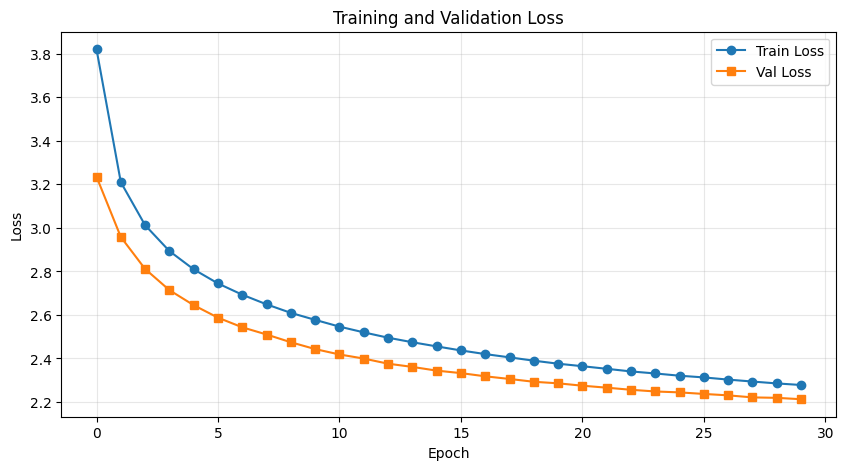

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
def greedy_search(model, image_features, max_length, start_token, end_token):
    model.eval()
    with torch.no_grad():
        encoder_hidden = model.encoder(image_features)
        h = encoder_hidden.unsqueeze(0).repeat(model.num_layers, 1, 1)
        c = torch.zeros_like(h)
        current_word = torch.tensor([[start_token]]).to(device)
        generated = [start_token]
        for _ in range(max_length):
            output, (h, c) = model.decoder(current_word, (h, c))
            predicted = output.argmax(dim=2).item()
            generated.append(predicted)
            if predicted == end_token:
                break
            current_word = torch.tensor([[predicted]]).to(device)
    return generated

In [25]:
def beam_search(model, image_features, max_length, start_token, end_token, beam_width=3):
    model.eval()
    with torch.no_grad():
        encoder_hidden = model.encoder(image_features)
        h = encoder_hidden.unsqueeze(0).repeat(model.num_layers, 1, 1)
        c = torch.zeros_like(h)
        sequences = [[[start_token], 0.0, h, c]]
        for _ in range(max_length):
            all_candidates = []
            for seq, score, h_state, c_state in sequences:
                if seq[-1] == end_token:
                    all_candidates.append([seq, score, h_state, c_state])
                    continue
                current_word = torch.tensor([[seq[-1]]]).to(device)
                output, (new_h, new_c) = model.decoder(current_word, (h_state, c_state))
                probs = torch.log_softmax(output[0, 0], dim=0)
                top_probs, top_indices = probs.topk(beam_width)
                for i in range(beam_width):
                    candidate = [seq + [top_indices[i].item()], score + top_probs[i].item(), new_h, new_c]
                    all_candidates.append(candidate)
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            sequences = ordered[:beam_width]
        return sequences[0][0]

 Found images at: /kaggle/input/flickr30k/Images


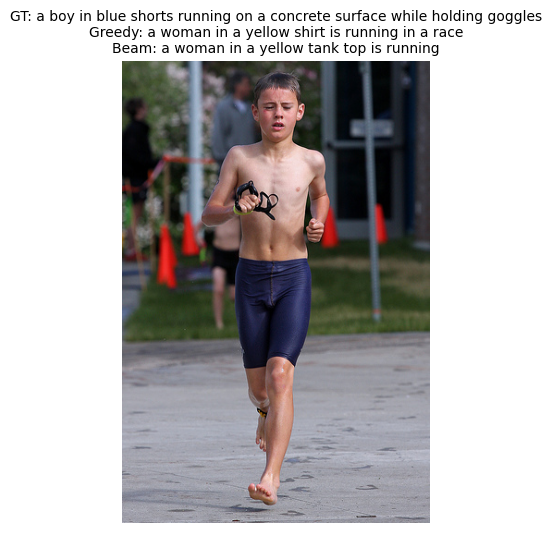

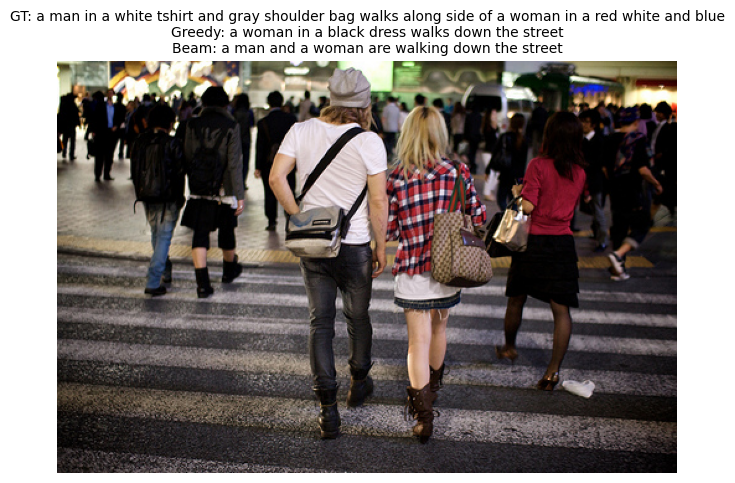

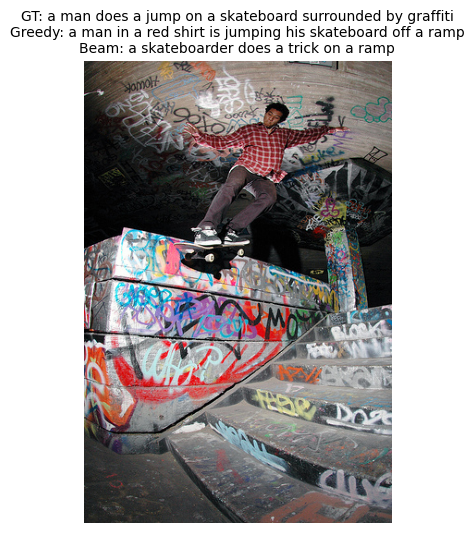

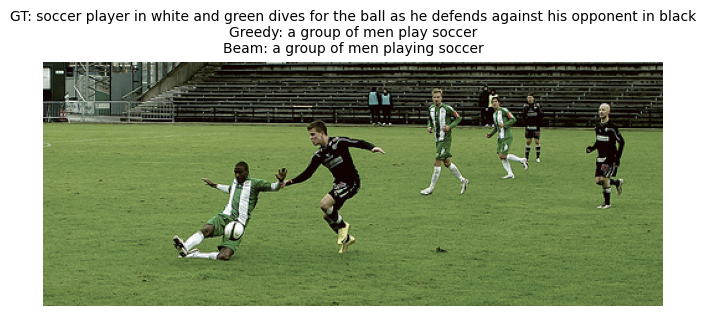

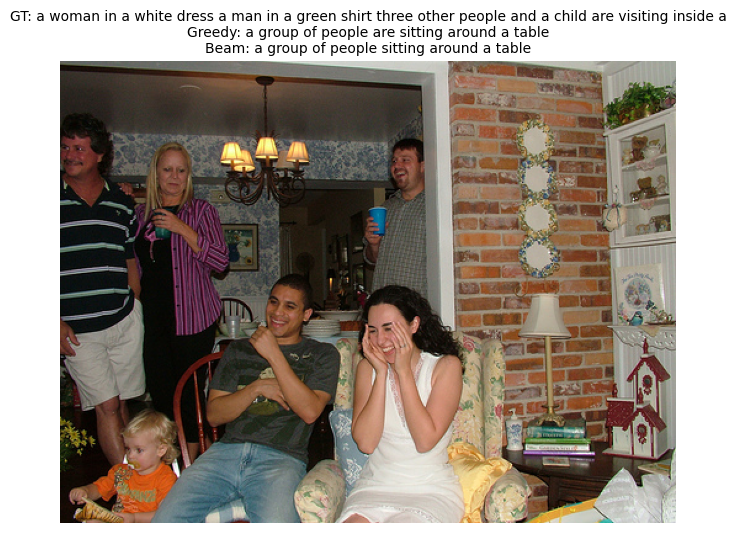

In [26]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

image_dir = find_image_dir()

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

test_images = random.sample(val_dataset.images, 5)
START_IDX = word2idx['<start>']
END_IDX = word2idx['<end>']
for img_name in test_images:
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    features = torch.tensor(image_features[img_name]).unsqueeze(0).to(device)
    greedy_caption = greedy_search(model, features, MAX_LENGTH, START_IDX, END_IDX)
    beam_caption = beam_search(model, features, MAX_LENGTH, START_IDX, END_IDX, beam_width=3)
    greedy_words = ' '.join([idx2word[idx] for idx in greedy_caption if idx not in [PAD_IDX, START_IDX, END_IDX]])
    beam_words = ' '.join([idx2word[idx] for idx in beam_caption if idx not in [PAD_IDX, START_IDX, END_IDX]])
    gt_caption = image_to_captions[img_name][0]
    gt_words = ' '.join([idx2word[idx] for idx in gt_caption if idx not in [PAD_IDX, START_IDX, END_IDX]])
    plt.title(f"GT: {gt_words}\nGreedy: {greedy_words}\nBeam: {beam_words}", fontsize=10)
    plt.show()

In [27]:
references = []
hypotheses_greedy = []
hypotheses_beam = []
for img_name in tqdm(val_dataset.images[:500], desc="Evaluating"):
    features = torch.tensor(image_features[img_name]).unsqueeze(0).to(device)
    greedy_caption = greedy_search(model, features, MAX_LENGTH, START_IDX, END_IDX)
    beam_caption = beam_search(model, features, MAX_LENGTH, START_IDX, END_IDX, beam_width=3)
    greedy_words = [idx2word[idx] for idx in greedy_caption if idx not in [PAD_IDX, START_IDX, END_IDX]]
    beam_words = [idx2word[idx] for idx in beam_caption if idx not in [PAD_IDX, START_IDX, END_IDX]]
    ref_captions = [[idx2word[idx] for idx in cap if idx not in [PAD_IDX, START_IDX, END_IDX]] for cap in image_to_captions[img_name]]
    references.append(ref_captions)
    hypotheses_greedy.append(greedy_words)
    hypotheses_beam.append(beam_words)
bleu_greedy = corpus_bleu(references, hypotheses_greedy)
bleu_beam = corpus_bleu(references, hypotheses_beam)
print(f"BLEU-4 (Greedy): {bleu_greedy:.4f}")
print(f"BLEU-4 (Beam): {bleu_beam:.4f}")

Evaluating: 100%|██████████| 500/500 [00:13<00:00, 37.81it/s]


BLEU-4 (Greedy): 0.2090
BLEU-4 (Beam): 0.2319


In [28]:
def calculate_token_metrics(references, hypotheses):
    precisions = []
    recalls = []
    f1s = []
    for refs, hyp in zip(references, hypotheses):
        hyp_tokens = set(hyp)
        ref_tokens = set()
        for ref in refs:
            ref_tokens.update(ref)
        if len(hyp_tokens) == 0:
            precisions.append(0)
            recalls.append(0)
            f1s.append(0)
            continue
        tp = len(hyp_tokens & ref_tokens)
        precision = tp / len(hyp_tokens) if len(hyp_tokens) > 0 else 0
        recall = tp / len(ref_tokens) if len(ref_tokens) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

print("Calculating token-level metrics...")
prec, rec, f1 = calculate_token_metrics(references, hypotheses_beam)
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

Calculating token-level metrics...
Precision: 0.6632
Recall: 0.1775
F1-Score: 0.2755


In [29]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab': vocab,
    'word2idx': word2idx,
    'idx2word': idx2word,
    'max_length': MAX_LENGTH
}, 'final_model.pth')
print("Final model saved!")

Final model saved!
